### Problem Statement :: E-commerece Product Recommendation Model

### Step 0: Load Packages and Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix


plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

### Step 1: Data Loading and Preprocessing

In [8]:
# Read your dataset 
df = pd.read_csv('C:/Dataset/walmart_com_product_review.tsv', sep='\t')
df.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [9]:
df = df[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
df.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


### Basic Operations

In [10]:
df['Product Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Product Tags, Length: 5000, dtype: object

In [11]:
df.shape

(5000, 10)

In [12]:
df.describe()

,Product Rating,Product Reviews Count
count,2194.000000,3346.000000
mean,4.294622,571.035565
std,0.773311,2485.699363
min,1.000000,1.000000
25%,4.000000,3.000000
50%,4.500000,20.000000
75%,4.800000,170.000000
max,5.000000,29242.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Uniq Id                5000 non-null   object 
 1   Product Id             5000 non-null   object 
 2   Product Rating         2194 non-null   float64
 3   Product Reviews Count  3346 non-null   float64
 4   Product Category       4990 non-null   object 
 5   Product Brand          4987 non-null   object 
 6   Product Name           5000 non-null   object 
 7   Product Image Url      5000 non-null   object 
 8   Product Description    3873 non-null   object 
 9   Product Tags           5000 non-null   object 
dtypes: float64(2), object(8)
memory usage: 390.8+ KB


In [14]:
# GET NUM OF COLOMS AND ROWS
print(f"Number of column :{df.shape[1]}\nNumber of rows :{df.shape[0]}")

Number of column :10
Number of rows :5000


In [15]:
pd.DataFrame({'count': df.shape[0], 
              'nulls': df.isnull().sum(), 
              'nulls%': df.isnull().mean() * 100, 
              'cardinality': df.nunique(),
              'duplicated':df.duplicated().sum(),
              'datatype':df.dtypes
             })

,count,nulls,nulls%,cardinality,duplicated,datatype
Uniq Id,5000,0,0.00,5000,0,object
Product Id,5000,0,0.00,4802,0,object
Product Rating,5000,2806,56.12,35,0,float64
Product Reviews Count,5000,1654,33.08,777,0,float64
Product Category,5000,10,0.20,988,0,object
Product Brand,5000,13,0.26,1600,0,object
Product Name,5000,0,0.00,4921,0,object
Product Image Url,5000,0,0.00,4945,0,object
Product Description,5000,1127,22.54,3759,0,object
Product Tags,5000,0,0.00,4921,0,object


In [19]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
df['Product Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
df['Product Reviews Count'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
df['Product Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
df['Product Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
df['Product Description'].fillna('', inplace=True)

In [20]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [22]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
df.rename(columns=column_name_mapping, inplace=True)

In [24]:
df['ID'] = df['ID'].str.extract(r'(\d+)').astype(float)
df['ProdID'] = df['ProdID'].str.extract(r'(\d+)').astype(float)

### Step 2: EDA (Exploratory Data Analysis)

In [25]:
# Basic statistics
num_users = df['ID'].nunique()
num_items = df['ProdID'].nunique()
num_ratings = df['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


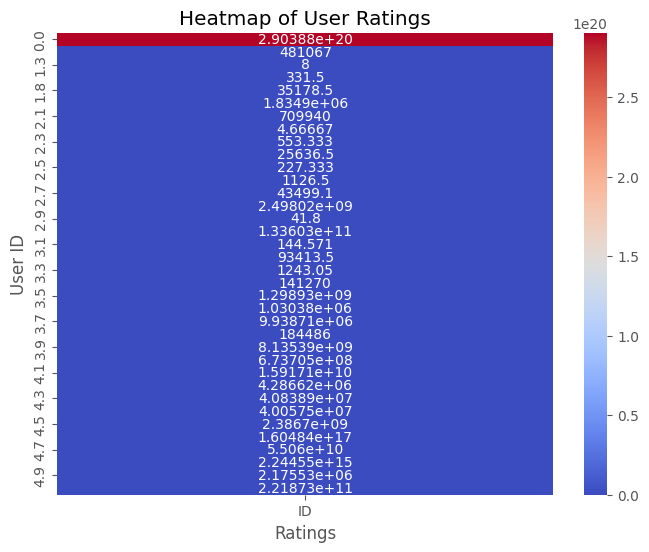

In [26]:
# Pivot the DataFrame to create a heatmap
heatmap_data = df.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

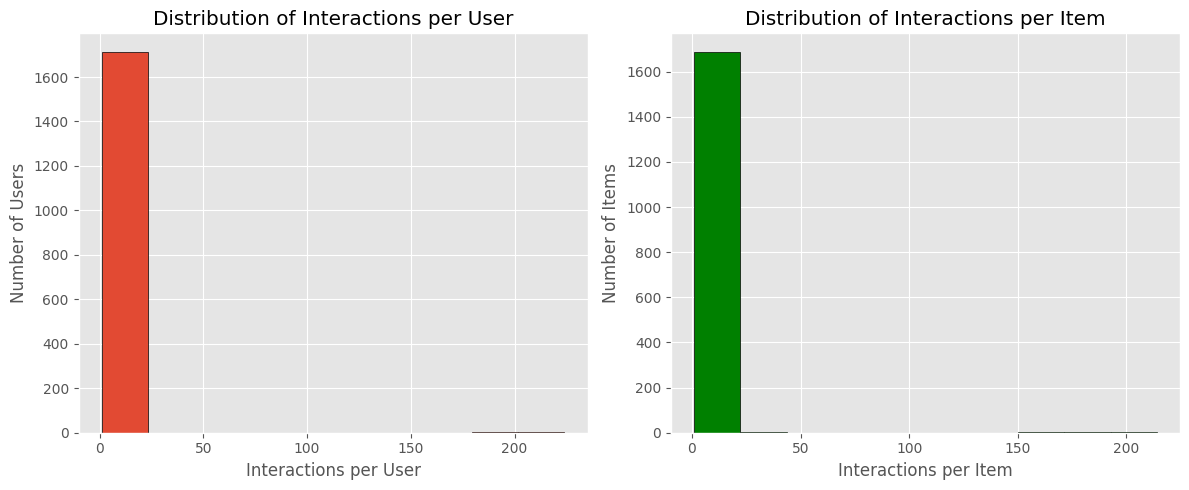

In [27]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
df['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

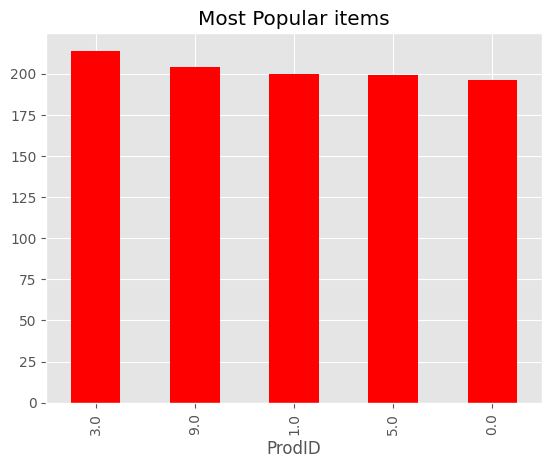

In [28]:
# Most popular items
popular_items = df['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

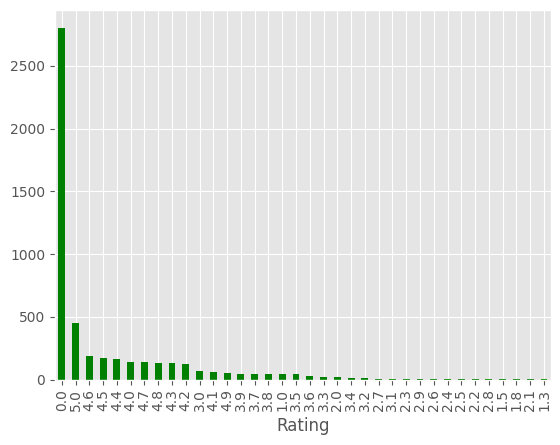

In [30]:
# most rated counts
df['Rating'].value_counts().plot(kind='bar',color='green')

### Step 3: Data Cleaning and Tags Creations

In [35]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')

def clean_and_extract_tags(text):
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    df[column] = df[column].apply(clean_and_extract_tags)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ranesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Concatenate the cleaned tags from all relevant columns
df['Tags'] = df[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

### Rating Base Recommendations System

In [38]:
average_ratings = df.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [39]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [40]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

In [41]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


,Name,ReviewCount,Brand,ImageURL,Rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4,moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2,gold bond,https://i5.walmartimages.com/asr/34b610e7-05db...,5
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24,versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2,goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1,red devil,https://i5.walmartimages.com/asr/60bfe5ba-774c...,5
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1,air wick,https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4,bain de terre,https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12,long aid,https://i5.walmartimages.com/asr/f7f29199-bfa5...,5
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1,diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5


### Content Base Recommendation system (User Preferences or Items similarities)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(df['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [45]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = df[df['Name']==item_name].index[0]

In [46]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [47]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [48]:
df.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


### Function To Recommend Products for Content Base

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in df['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = df[df['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = df.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [50]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(df, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [51]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(df, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,kokie cosmetics,https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,kokie cosmetics,https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,kokie cosmetics,https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,l.a. colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,kokie cosmetics,https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,e.l.f. cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,l'oreal paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
3023,Be Matte Lipstick - Pink,2.0,city color,https://i5.walmartimages.com/asr/4425a13e-085f...,3.0


### Collaborative Filtering (User Item Similarity)

In [52]:
user_item_matrix = df.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)

In [53]:
user_similarity = cosine_similarity(user_item_matrix)

In [54]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [55]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [56]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)
    
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = df[df['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [57]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,design essentials,https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
78,"Paul Sebastian Fine Cologne Spray, Cologne for...",28.0,paul sebastian,https://i5.walmartimages.com/asr/03d08a07-18d7...,4.8
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
92,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.0
94,Ag Hair Cosmetics Ultradynamics Extra-Firm Fin...,0.0,ag hair,https://i5.walmartimages.com/asr/5d217d98-a385...,0.0
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0


### Function That Recommend Items

In [60]:
def collaborative_filtering_recommendations(df, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = df.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = df[df['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(df, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,l'oreal paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.1
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.0
155,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.0
174,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,covergirl,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.0
193,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.5
212,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.0
241,"Ahava Mens Mineral Hand Cream, 3.4 Oz",0.0,ahava,https://i5.walmartimages.com/asr/f74e4bb7-47d3...,0.0


### Hybrid Recommendations

In [64]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(df,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(df,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(df,target_user_id, top_n)
    
    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()
    
    return hybrid_rec.head(10)

In [65]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(df,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


In [66]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(df,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,black radiance,https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,black radiance,https://i5.walmartimages.com/asr/fe3da48f-5142...,4.3
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,l.a. colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,kokie cosmetics,https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,kokie cosmetics,https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,kokie cosmetics,https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,kokie cosmetics,https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4872,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,l.a. colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.8
1300,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,e.l.f. cosmetics,https://i5.walmartimages.com/asr/58220de4-3875...,4.1
420,Black Opal Color Splurge Sassy Luxe Matte Lips...,0.0,black opal,https://i5.walmartimages.com/asr/a991241b-e4ad...,0.0
